# Customer Churn Prediction: EDA, Preprocessing, Model Comparison and Feature Engineering
## Project Overview & Problem Statement
The project focuses on predicting customer churn in Telka, a fictional national telcom provider. Churn refers to customers leaving a service provider and predicting churn is cricial in improving customer retention and business profitablility.

The problem is fomulated as a supervised learning task where the aim and goal is to predict a binary outcome. This is, whether a customer will churn (`Yes`) or not (`No`).

Since the target variable is categorical with tow possible outcomes, this is a binary classification problem. Various classification algorithms will be employed and compared against one another to build a robust predictive model. Through this project, I aim to get an understanding of the features that most strongly influence customer churn and evaluate model perfomance using the appropriate metrics i.e. ROC-AUC, F1-Score. This is to identify the best-performing supervised learning approach for this classification task.

## Data Source
The dataset used in this project is the Telco Customer Churn dataset that contains customer information from a telecommunications company. This dataset contains demographic, account, and service data as well as whether the customer has churned or not. The target variable is `Churn` that indicates whether the customer left (`Yes`) or stayed (`No`).

The dataset is publicly available on Kaggle: [Telco Customer Churn - Kaggle](https://www.kaggle.com/datasets/blastchar/telco-customer-churn/data)

There is also a more extensive version of this dataset published by IBM that includes more features and additional records. However, for the project scope, I shall use the Kaggle version due to its simpler structure which is more manageable for showing supervised learning techniques while keeping within the project constraints.

## Dataset Explanation
The dataset contains 7403 rows (customers) and 21 features (20 features + 1 target). It is in tabular format, with each row representing a customer and column representing a demographic, service-related or account-related variable.

Among the features:
- 3 are numerical i.e. `tenure`, `MonthlyCharges` `TotalCharges`
- 5 are binary i.e. `Dependents`, `SeniorCitizen`
- 13 are categorical i.e. `gender`, `InternetService`, etc.

The dataset is self-contained and thus does not require any merging of external data. This, coupled with the data being small in size (less than 1MB), making it manageable for EDA and model experimentation.

Here is a full list of the columns in the dataset:
- **customerID**: Unique ID for each customer
- **gender**: Gender of the customer (`Male` or `Female`)
- **SeniorCitizen**: Indicates if the customer is a senior (`1` = Yes, `0` = No)
- **Partner**: Whether the customer has a partner (`Yes` or `No`)
- **Dependents**: Whether the customer has dependents (`Yes` or `No`)
- **tenure**: Number of months the customer has been with the company
- **PhoneService**: Whether the customer has phone service (`Yes` or `No`)
- **MultipleLines**: Has multiple phone lines (`Yes`, `No`, or `No phone service`)
- **InternetService**: Type of internet service (`DSL`, `Fiber optic`, or `No`)
- **OnlineSecurity**: Whether online security is included (`Yes`, `No`, or `No internet service`)
- **OnlineBackup**: Whether online backup is included (`Yes`, `No`, or `No internet service`)
- **DeviceProtection**: Whether device protection is included (`Yes`, `No`, or `No internet service`)
- **TechSupport**: Whether tech support is included (`Yes`, `No`, or `No internet service`)
- **StreamingTV**: Access to streaming TV (`Yes`, `No`, or` No internet service`)
- **StreamingMovies**: Access to streaming movies (`Yes`, `No`, or `No internet service`)
- **Contract**: Type of contract (`Month-to-month`, `One year`, `Two year`)
- **PaperlessBilling**: Whether billing is paperless (`Yes` or `No`)
- **PaymentMethod**: Method of payment (`Electronic check`, `Mailed check`, etc.)
- **MonthlyCharges**: Monthly amount charged to the customer
- **TotalCharges**: Total amount charged over the tenure
- **Churn**: Target variable — whether the customer churned (`Yes` or `No`)

In [1]:
# Importing Libraries
import time
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.svm import SVC
from datetime import datetime
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.pipeline import Pipeline as ImbPipeline
from sklearn.model_selection import train_test_split, GridSearchCV
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, AdaBoostClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report, confusion_matrix

# Plot Customisation
%matplotlib inline
sns.set_theme(style = "whitegrid", palette = "Greens")

In [2]:
# Defining file variables
file_path = './data/customer_churn.csv'
result_path = './results/'
result_name = 'churn_report_model_results'
result_ext = '.csv'
results = {}

# Modelling Parameters
testing_size = 0.2
k_folds = 5
scoring = 'roc_auc'
rand_state = 42

# Target column
target = 'Churn'

## Exploratory Data Analysis
---
### Basic Exploration and Preprocessing

In [3]:
# Importing the Dataset
df = pd.read_csv(file_path, delimiter = ',')

# Preview
df.head()

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [4]:
# Dataset Shape, Columns and Datatypes
print(f'Shape: {df.shape}')
print(f'Columns: {df.columns.tolist()}')
print(f'\nColumn Datatypes:\n{df.dtypes}')

Shape: (7043, 21)
Columns: ['customerID', 'gender', 'SeniorCitizen', 'Partner', 'Dependents', 'tenure', 'PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'TechSupport', 'StreamingTV', 'StreamingMovies', 'Contract', 'PaperlessBilling', 'PaymentMethod', 'MonthlyCharges', 'TotalCharges', 'Churn']

Column Datatypes:
customerID           object
gender               object
SeniorCitizen         int64
Partner              object
Dependents           object
tenure                int64
PhoneService         object
MultipleLines        object
InternetService      object
OnlineSecurity       object
OnlineBackup         object
DeviceProtection     object
TechSupport          object
StreamingTV          object
StreamingMovies      object
Contract             object
PaperlessBilling     object
PaymentMethod        object
MonthlyCharges      float64
TotalCharges         object
Churn                object
dtype: object


`SeniorCitizen` is a binary column and it is alread of `int64` type, however we need to convert other columns, that are binary, like `gender`, `Partner` and `Dependents`, etc to `category` type.

In general, we have three category types. These are:
1. Numerical Columns
2. Categorical Columns
3. Binary Columns

It is also important to consider separating features based on their domain such as service, demographic and payment features. This will help in understanding the data as we further explore it. 

An important thing to note is that `TotalCharges` is an `object` type column while it is supposed to be numerical. This is likely due to some presence of non-numeric values. We need to convert it to numeric type and handle any arising errors from the conversion. 

In [5]:
# Unique Values in each column
for col in df.columns:
    print(f'{col}: {df[col].nunique()} unique values: {df[col].unique()} unique values.\n')

customerID: 7043 unique values: ['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK'] unique values.

gender: 2 unique values: ['Female' 'Male'] unique values.

SeniorCitizen: 2 unique values: [0 1] unique values.

Partner: 2 unique values: ['Yes' 'No'] unique values.

Dependents: 2 unique values: ['No' 'Yes'] unique values.

tenure: 73 unique values: [ 1 34  2 45  8 22 10 28 62 13 16 58 49 25 69 52 71 21 12 30 47 72 17 27
  5 46 11 70 63 43 15 60 18 66  9  3 31 50 64 56  7 42 35 48 29 65 38 68
 32 55 37 36 41  6  4 33 67 23 57 61 14 20 53 40 59 24 44 19 54 51 26  0
 39] unique values.

PhoneService: 2 unique values: ['No' 'Yes'] unique values.

MultipleLines: 3 unique values: ['No phone service' 'No' 'Yes'] unique values.

InternetService: 3 unique values: ['DSL' 'Fiber optic' 'No'] unique values.

OnlineSecurity: 3 unique values: ['No' 'Yes' 'No internet service'] unique values.

OnlineBackup: 3 unique values: ['Yes' 'No' 'No internet service'] unique v

From the output, we can see `gender`, `Patner`, `Dependents`, `PhoneService`, `PaperlessBilling` and `Churn` columns have binary values. On the other hand, the `MultipleLines`, `InternetService`, `OnlineSecurity`, `OnlineBackup`, `DeviceProtection`, `TechSupport`, `StreamingTV` and `StreamingMovies` are categorical with multiple unique values. 

The `Contract` and `PaymentMethod` columns also have categorical values.

In [6]:
# Separating Features by Domain
demographic_features = ['gender', 'SeniorCitizen', 'Partner', 'Dependents']

service_features = ['PhoneService', 'MultipleLines', 'InternetService', 'OnlineSecurity', 'OnlineBackup', 'DeviceProtection', 'StreamingTV', 'StreamingMovies', 'TechSupport']

payment_features = ['Contract', 'PaperlessBilling', 'PaymentMethod']

binary_features = ['gender', 'Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'SeniorCitizen']

categorical_features = list(set(service_features + payment_features) - set(binary_features))

numeric_features = ['tenure', 'MonthlyCharges', 'TotalCharges']

features = demographic_features + service_features + payment_features

In [7]:
# Handling the TotalCharges column
print(f'TotalCharges type before conversion: {df['TotalCharges'].dtype}\nTotal null values: {df['TotalCharges'].isna().sum()}')

# Converting to Numeric
df['TotalCharges'] = pd.to_numeric(df['TotalCharges'], errors = 'coerce')

TotalCharges type before conversion: object
Total null values: 0


While converting `TotalCharges` to numeric, we use the `errors = 'coerce'` to convert any non-numeric values to `NaN`. This becomes crucial because it allows us to handle any invalid entries without causing the conversion to fail. After this process, we decide on how to handle the `NaN` values. We have a two options:
1. Dropping them
2. Filling them with a specific value

In [8]:
# Checking on the count on `NaN` values
print(f'TotalCharges type after conversion: {df['TotalCharges'].dtype}\nTotal null values: {df['TotalCharges'].isna().sum()}')

TotalCharges type after conversion: float64
Total null values: 11


Now the `TotalCharges` datatype is `float64` but the conversion has also resulted in 11 `NaN` values. 

In [9]:
# Checking the contents of the `Nan` rows
temp_df = pd.read_csv(file_path, delimiter=',')
temp_df.loc[df[df['TotalCharges'].isnull()].index, 'TotalCharges']

488      
753      
936      
1082     
1340     
3331     
3826     
4380     
5218     
6670     
6754     
Name: TotalCharges, dtype: object

It can be ascertained that the null `TotalCharges` rows have no values which explains why they were converted to `NaN`. 

Since these rows do not provide any useful information for this analysis coupled with their small number (11), we can safely drop them from the dataframe we are working with.

In [10]:
# Dropping the null value rows in `TotalCharges`
df = df.dropna(subset = ['TotalCharges'])

# Preview
print(f'Total null values: {df['TotalCharges'].isna().sum()}')

Total null values: 0


As we saw in the sample that we got from `df.head()` above, the `customerID` column is a unique identifier column that just shows that each customer is unique. We also confirmed that there are no duplicated values in our datatype and unique values output above. 

As such, this does not really have any use in going through our analysis. We can drop this column.

<!--  -->

In [11]:
# Dropping the CustomerID column
df = df.drop(columns = ['customerID'], axis = 1)

# Preview
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,Female,0,Yes,No,1,No,No phone service,DSL,No,Yes,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,Male,0,No,No,34,Yes,No,DSL,Yes,No,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,Male,0,No,No,2,Yes,No,DSL,Yes,Yes,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,Male,0,No,No,45,No,No phone service,DSL,Yes,No,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,Female,0,No,No,2,Yes,No,Fiber optic,No,No,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [12]:
# Checking for Null and Duplicated values
print(f'Null values in dataset: {df.isna().sum().sum()}')
print(f'Duplicated values in dataset: {df.duplicated().sum()}')

Null values in dataset: 0
Duplicated values in dataset: 22


We have 22 duplicated rows in the dataset. However, there is no cause for concern as we know and have ascertained that these belong to different customers. We also have 0 null values which is super great!

### Target Variable Distribution

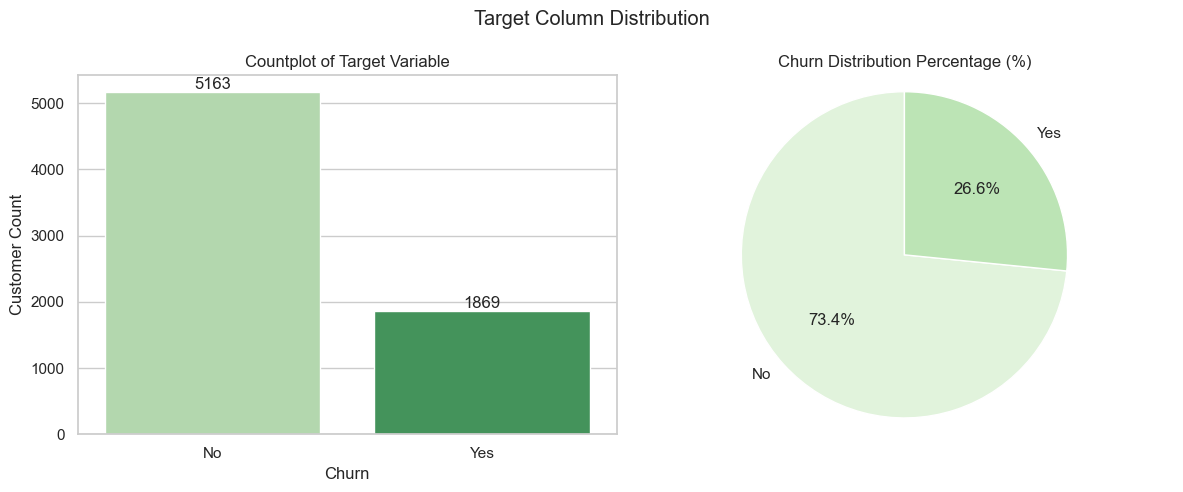

In [13]:
# Creating the figure
fig, axes = plt.subplots(1, 2, figsize = (12, 5))

# Left Plot: Countplot
sns.countplot(data = df, x = target, ax = axes[0], hue = target, palette = 'Greens')
axes[0].set_title('Countplot of Target Variable')
axes[0].set_xlabel(target)
axes[0].set_ylabel('Customer Count')
    # Labelling the bars
for container in axes[0].containers:
    axes[0].bar_label(container)

# Right Plot: Pie Plot
churn_counts = df['Churn'].value_counts()
churn_percent = churn_counts / churn_counts.sum() * 100
axes[1].pie(churn_percent, labels = churn_percent.index, autopct = '%1.1f%%', startangle = 90)
axes[1].set_title('Churn Distribution Percentage (%)')
axes[1].axis('equal')

# Customising Overall Plot
plt.suptitle('Target Column Distribution')
plt.tight_layout()

# Showing the Plot
plt.show();

Looking at the `Churn` distribution, it is clear that the distribution is imbalanced. Here, we have a significatnly higher number of customers that did not churn (`Yes`) compared to the ones that did churn (`No`). This will require some special attention when training our model to ensure that the model does not become biased towards the majority class.

### Numerical Feature Analysis
Here we will look at the distribution of the numerical features and their correlation with the target variable `Churn`.

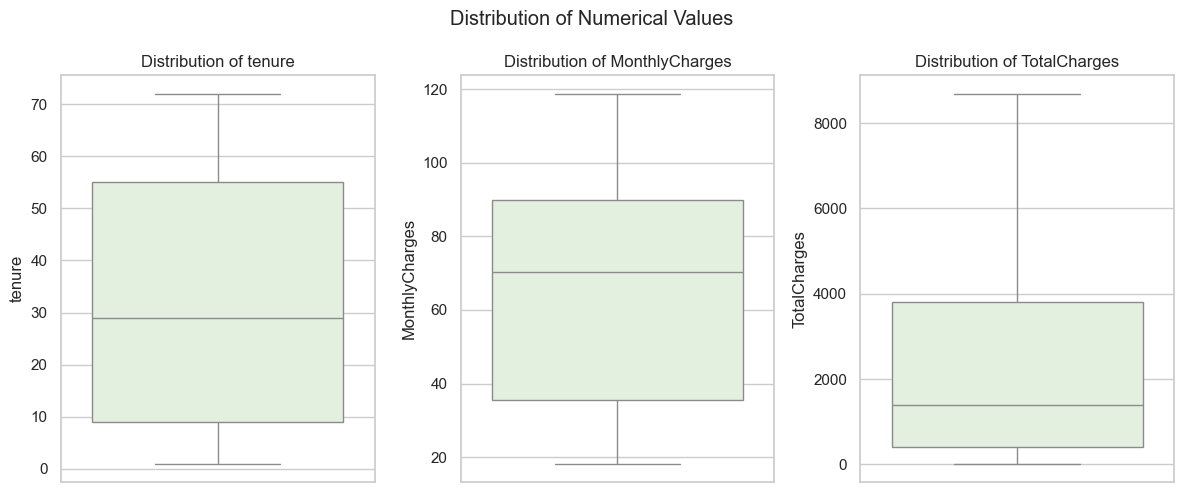

In [14]:
# Creating the Figure
plt.figure(figsize = (12, 5))

# Creating the Plot
for i in range(0, len(numeric_features)):
    plt.subplot(1, len(numeric_features), i + 1)
    sns.boxplot(data = df, y = numeric_features[i])
    plt.title(f'Distribution of {numeric_features[i]}')

# Customising the Plot
plt.suptitle('Distribution of Numerical Values')
plt.tight_layout()

# Showing the Plot
plt.show();

#### Analysis of Numerical Features

The boxplots for `tenure`, `MonthlyCharges` and `TotalCharges` give insight into the distribution and spread of the numerical values. 

The `tenure` feature shows a relatively wide distribution with a median of about 29 months. There are no visible outliers which indicates a stable distribution of contract lengths.

The `MonthlyCharges` feature is moderately right-skewed with most cusomers paying between $35 and $90 per month. There are no particular outliers in this too, suggesting that even premium-tier customers fall within a reasonable price range.

Considering the `TotalCharges` feature, we see a significant right-skew as evidenced by the long tail stretching to the right. Although some customers have paid a lot over time, these values are within expected bounds and are not treated as outliers.

The numerical features appear within reason (well-behaved) and do not require special treatment for the outliers.

To understand the relation between the distributions and the target variable `Churn` we have to plot the distribution by the churn status.

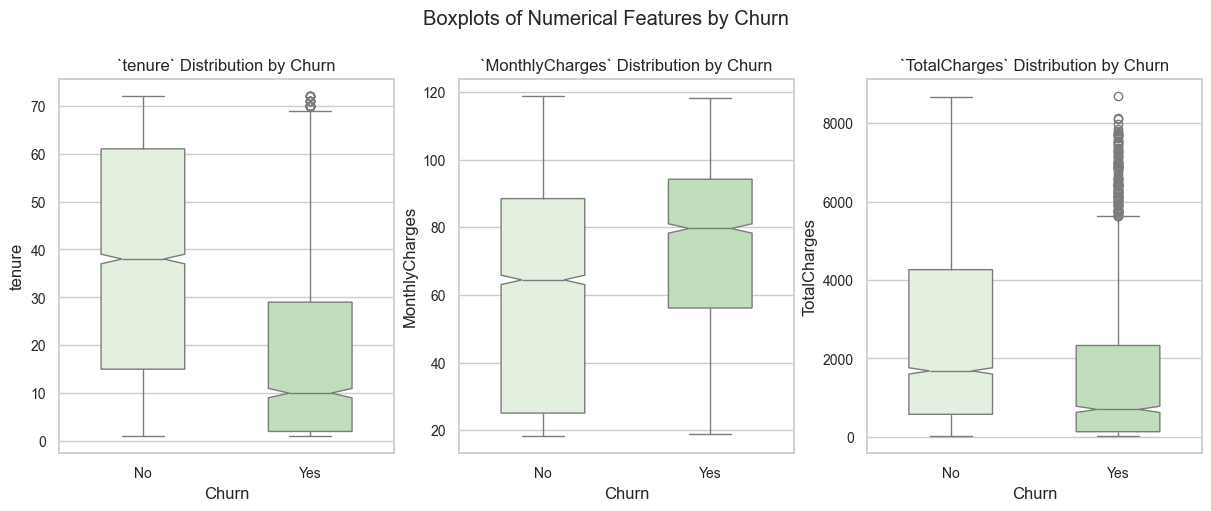

In [15]:
# Creating the Figure
fig, axes = plt.subplots(1, len(numeric_features), figsize = (12, 5), constrained_layout = True)

# Creating the Plots
for i, col in enumerate(numeric_features):
    sns.boxplot(data = df, x = target, y = col, ax = axes[i], hue = target, width = 0.5, notch = True)
    axes[i].set_title(f'`{col}` Distribution by Churn')
    axes[i].set_xlabel(target)
    axes[i].set_ylabel(col)
    axes[i].tick_params(labelsize = 10)

# Customising Plot
plt.suptitle('Boxplots of Numerical Features by Churn\n')

# Showing the Plot
plt.show();

The boxplots clearly show different patterns in the numerical features by target (`Churn`) status.

Customers that did not churn have a higher median `tenure` in contrast to those that churned. This would mean that loyal customers tend to stay longer. On the other hand, customers who churned tend to have very short tenures (median), suggesting that they may leave early in their contract period.

For `MonthlyCharges`, customers who churn generally pay more on average than those who stay. This could suggest that higher monthly costs may lead to dissatisfaction or affordability issues. 

The `TotalCharges` feature shows a big difference in behaviour. As a product of `tenure` and `MonthlyCharges`, it makes sense that the customers that churned have much lower `TotalCharges`. This supports the idea that customers that churn leave early.

Overall, these numerical features provide useable signals in predicting for churn.

To explore this a little further, we could look at the histograms with KDE (Kernel Density Estimate) of the numerical features. Here, we will be able to visualise the distribution of values and identify any skewness or unusual patters.

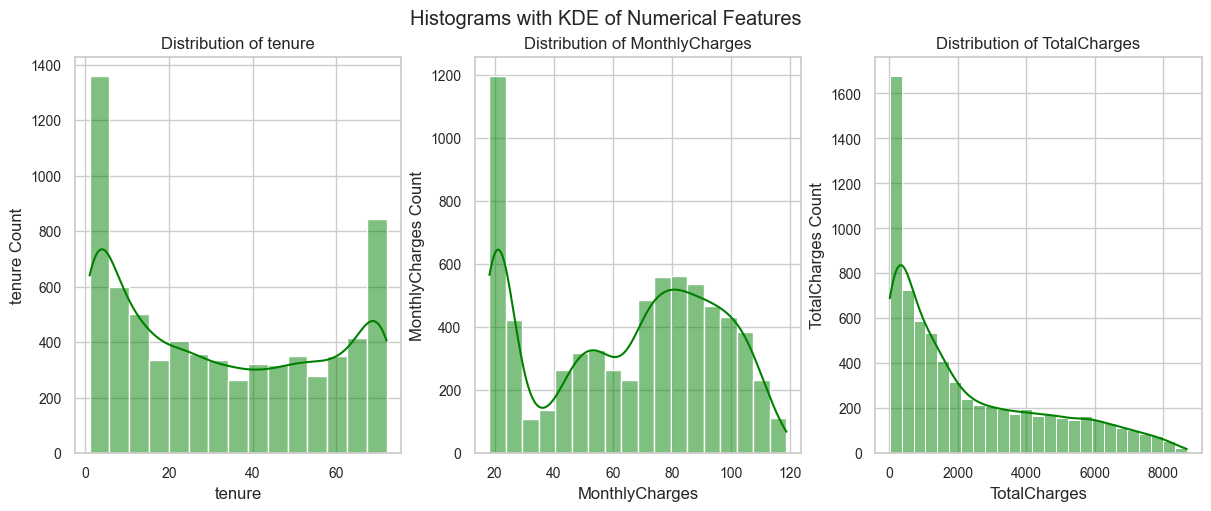

In [16]:
# Creating the Figure
fig, axes = plt.subplots(1, len(numeric_features), figsize = (12, 5), constrained_layout = True)

# Creatign the Plots
for i, col in enumerate(numeric_features):
    sns.histplot(data = df, x = col, kde = True, color = 'green', edgecolor = 'white', ax = axes[i])
    axes[i].set_title(f'Distribution of {col}')
    axes[i].set_xlabel(col)
    axes[i].set_ylabel(f'{col} Count')
    axes[i].tick_params(labelsize = 10)

# Customising the Plot
fig.suptitle('Histograms with KDE of Numerical Features')

# Showing the plot
plt.show();

The histograms with KDE curves indeed give a deeper view of how the numerical features are distributed. 

In this, we see that the `tenure` variable shows a **bimodal pattern** with many customers at the beginning and another peak at about 70 months. This shows that some customers tend to leave very early while others stay on for a number of years.

`MonthlyCharges` appears to be rightly-skewed. We have a concentration of customers between 70 and 90 dollars per month. However, it should noted that there is also a high proportion of customers who are paying less than 30 dollars monthly. 

The `TotalCharges` feature is strongly skewed to the right. This is not a surprise as it accumulates over time and is based on both tenure and monthly charges. Many customers have low total charges which is likely due to a shorter tenure.

The above distributions evidence that feature scaling and, or transformations might find use before modelling.

Next, we can consider the use of pairplots (`sns.pairplot`) to visualise the relationship between the `numerical features` and `Churn`. We will be able to see how the `numerical features` interact with `Churn`.

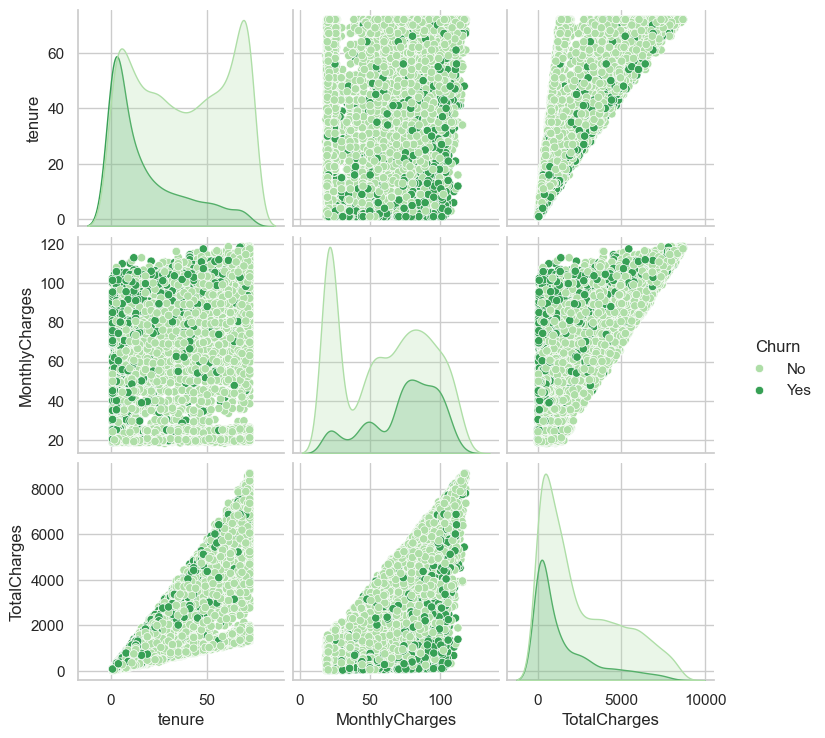

In [17]:
# Creating the Plot
sns.pairplot(data = df[numeric_features + [target]], hue = target, palette = 'Greens')

# Showing the Plot
plt.show();

The pairplot shows the relationships between `tenure`, `MonthlyCharges` and `TotalCharges`, coloured by churn status.

From the plot, we can see that customers that churn have a shorter `tenure` and lower `TotalCharges`. It is important to note that they often have higher `MonthlyCharges`. This supports that earlier suggestions that customers that churn tend to have higher `MonthlyCharges`.

There is also a strong positive linear relationship between `tenure` and `TotalCharges`. Again, this is expected because long-tenure customers would have higher `TotalCharges`. Overall, this plot confirms that the numerical features are important and useful for distinguishing between churned and reatined customers.

Now, we can look at a correlation matrix of the numerical features by the churn status. This will help us quantify the relationship between our features and identify strong correlations.

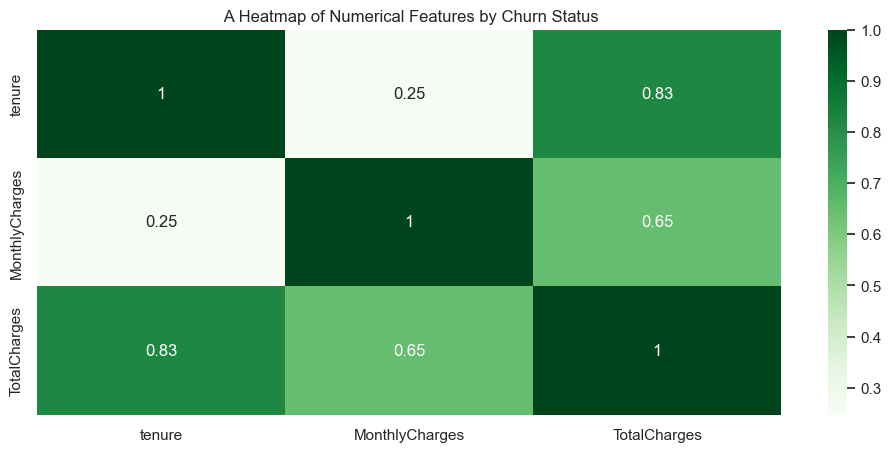

In [18]:
# Creating the Figure
plt.figure(figsize = (12, 5))

# Creating the Plot
corr_matrix = df[numeric_features].corr()
sns.heatmap(data = corr_matrix, annot = True, cmap = 'Greens')

# Customising the Plot
plt.title(' A Heatmap of Numerical Features by Churn Status')

# Showing the plot
plt.show();


##### VIF Analysis
To get a better understanding of the correlation of the features, we look at the VIF (Variance Inflaction Factor) of the features. VIF aids in the identification of multicollinearity among features. A **high VIF** indicates that a feature is **highly correlated** with other features. This is a problem in model training.

In [19]:
# Converting the target to binary
df[target] = df[target].map({'Yes': 1, 'No': 0})

# Defining the X
X = df[numeric_features].copy()

# Computing VIF
vif_data = pd.DataFrame()
vif_data['Feature'] = X.columns
vif_data['VIF'] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

# Printing Results
print(vif_data)

          Feature       VIF
0          tenure  6.332432
1  MonthlyCharges  3.361075
2    TotalCharges  8.079181


The results show that `TotalCharges` has a high VIF value of 8.08. This indicates strong multicollinearity with the other features. This makes sense since we had come to the understanding that `TotalCharges` is derived from the multiplication of `tenure` and `MonthlyCharges`.

In contrast, `tenure` and `MonthlyCharges` have lower VIF values of 6.33 and 3.36, respectively. These are within acceptable ranges. 

These findings suggest that if we end up using Linear Models such as `LogisticRegression`, it may be beneficial to drop `TotalCharges` to avoid the instability that would be caused by multicollinearity. However, in tree-based models like `RandomForest`, all features can be safely included.

##### Summary of Numerical Feature Importance

Based on the exploratory analysis through the use of boxplots, distribution plots, pairplots and the correlation matrix, we can draw some conclusions about the significance of features in relation to the target variable `Churn`.

The `tenure` feature appears to be the most significant indicator of churn. Customers who churn tend to have a shorter tenure. This suggests that customers who churn tend to do so early in the customer lifecycle. This is visible in the boxplots and pairplots where churned customers tend to concentrate in the lower tenure range.

`MonthlyCharges` shows a moderate correlation with `Churn`. In this, we saw that customers that tend to churn tend to also have higher monthly fees. This could point to dissatisfaction or affordability issues, as earlier stated. Although the relationship is weaker in comparison to the one between `tenure` and `Churn`, it still adds meaningful information.

On the other hand, `TotalCharges` is highly correlated with `tenure` (coefficient $\approx$ 0.83) and is largely derived from it. Even though it is a depiction of overall customer spending, it may not add much independent value for churn predictions and could potentially introduce multicollinearity if used alongside `tenure`.

To verify this, we computed the VIF for each feature. The VIF for `TotalCharges` was 8.08 which is close to the common threshold of 10. This indicates a high degree of multicollinearity. In contrast, `tenure` and `MonthlyCharges` have acceptable VIF values of 6.33 and 3.36. This supports the conclusion that `tenure` and `MonthlyCharges` should be prioritised while `TotalCharges` should be excluded from linear models or used cautiously depending on the modelling technique.

In conclusion, `tenure` and `MonthlyCharges` are significant numerical features for predicting `Churn`.

### Categorical Feature Analysis
For categorical features, we first plot the distribution of each feature based on their values (categories) and then analyse their correlation with the target variable `Churn`. 

We will employ the use of countplots for the categorical features and a bar plot for the correlation analysis.

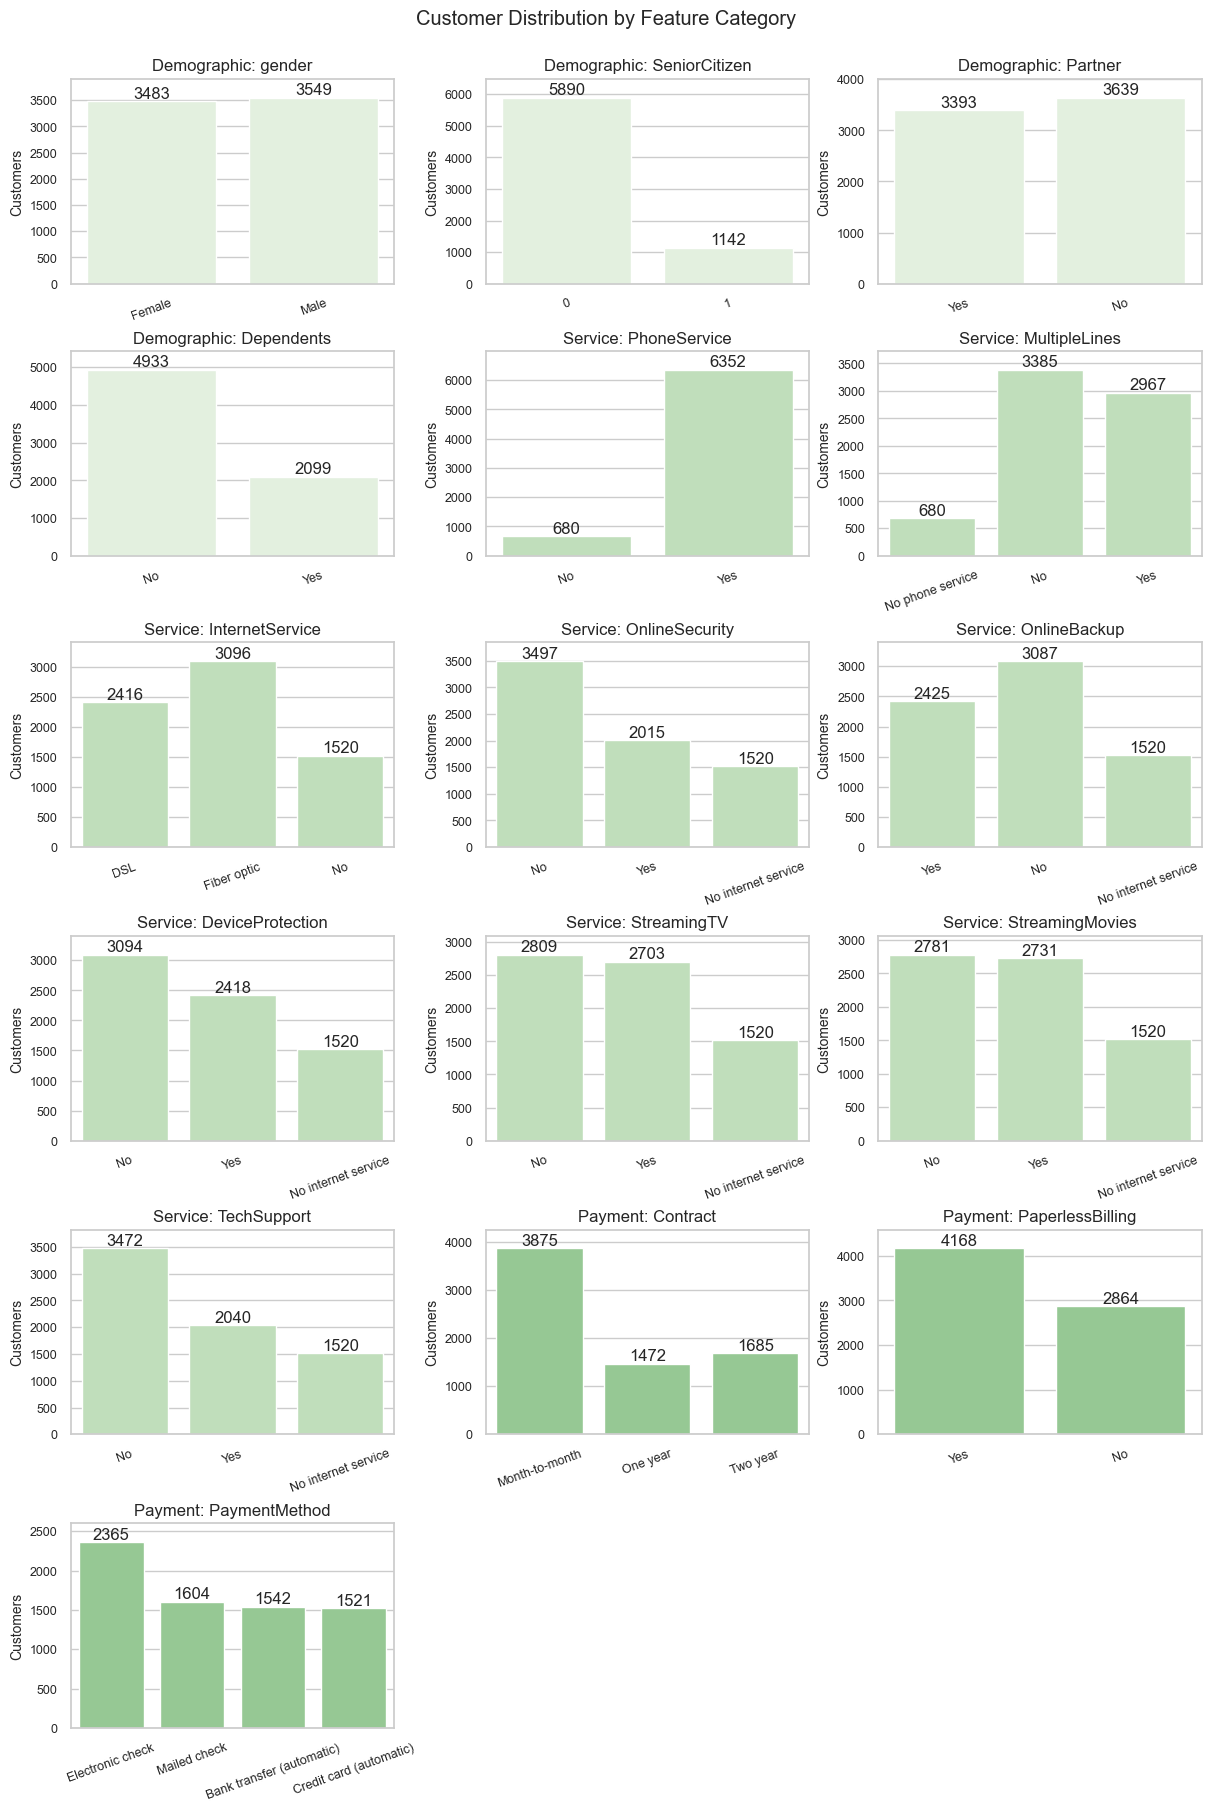

In [20]:
# Creating Plot Context
n_cols = 3
n_rows = (len(features) + n_cols - 1) // n_cols
feature_categories = (
    ['Demographic'] * len(demographic_features) +
    ['Service'] * len(service_features) +
    ['Payment'] * len(payment_features)
)

category_colors = {
'Demographic': sns.color_palette("Greens")[0],
'Service': sns.color_palette("Greens")[1],
'Payment': sns.color_palette("Greens")[2]
}

# Creating the Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, n_rows * 3), constrained_layout = True)
axes = axes.flatten()

# Creating the Plots
for i, feature in enumerate(features):
    ax = axes[i]
    category = feature_categories[i]
    max_count = df[feature].value_counts().max()
    sns.countplot(x = df[feature], ax = ax, color = category_colors[category])
        # Creating the bar labels
    for container in ax.containers:
        ax.bar_label(container)

# Customising the Plots
    ax.set_title(f'{feature_categories[i]}: {feature}', fontsize = 12)
    ax.set_ylabel('Customers', fontsize = 10)
    ax.set_xlabel('', fontsize = 10)
    ax.set_ylim(0, max_count * 1.1)
    ax.tick_params(axis='x', labelrotation=20, labelsize=9)
    ax.tick_params(axis='y', labelsize=9)

# Customising the Figure
for j in range(len(features), len(axes)):
    axes[j].axis('off')
fig.suptitle('Customer Distribution by Feature Category\n')

# Showing the Plot
plt.show();

In the countplots we see the distribution of each categorical feature. 

In the `Demographic Features` we see quite a balanced distribution in `Gender` and in `Partner`. In `SeniorCitizen` we see that there are significantly more non-`SeniorCitizens` than there are. It is a similar case with `Dependents`.

For `Serivice Features`, we see that many customers have phone service and internet. However, fewer people use services such as tech support, device protection and online security. These services might affect whether a customer stays or leaves.

When looking at `Payment Features` we see that most of the customers are on month-on-month contracts and use electronic checks. These choices may be related to a higher risk of churn because short contracts and certain payment types often mean lower customer loyalty.

Now we can consider the correlation of these variables with `Churn`. Here we will use a bar plot for the analysis.

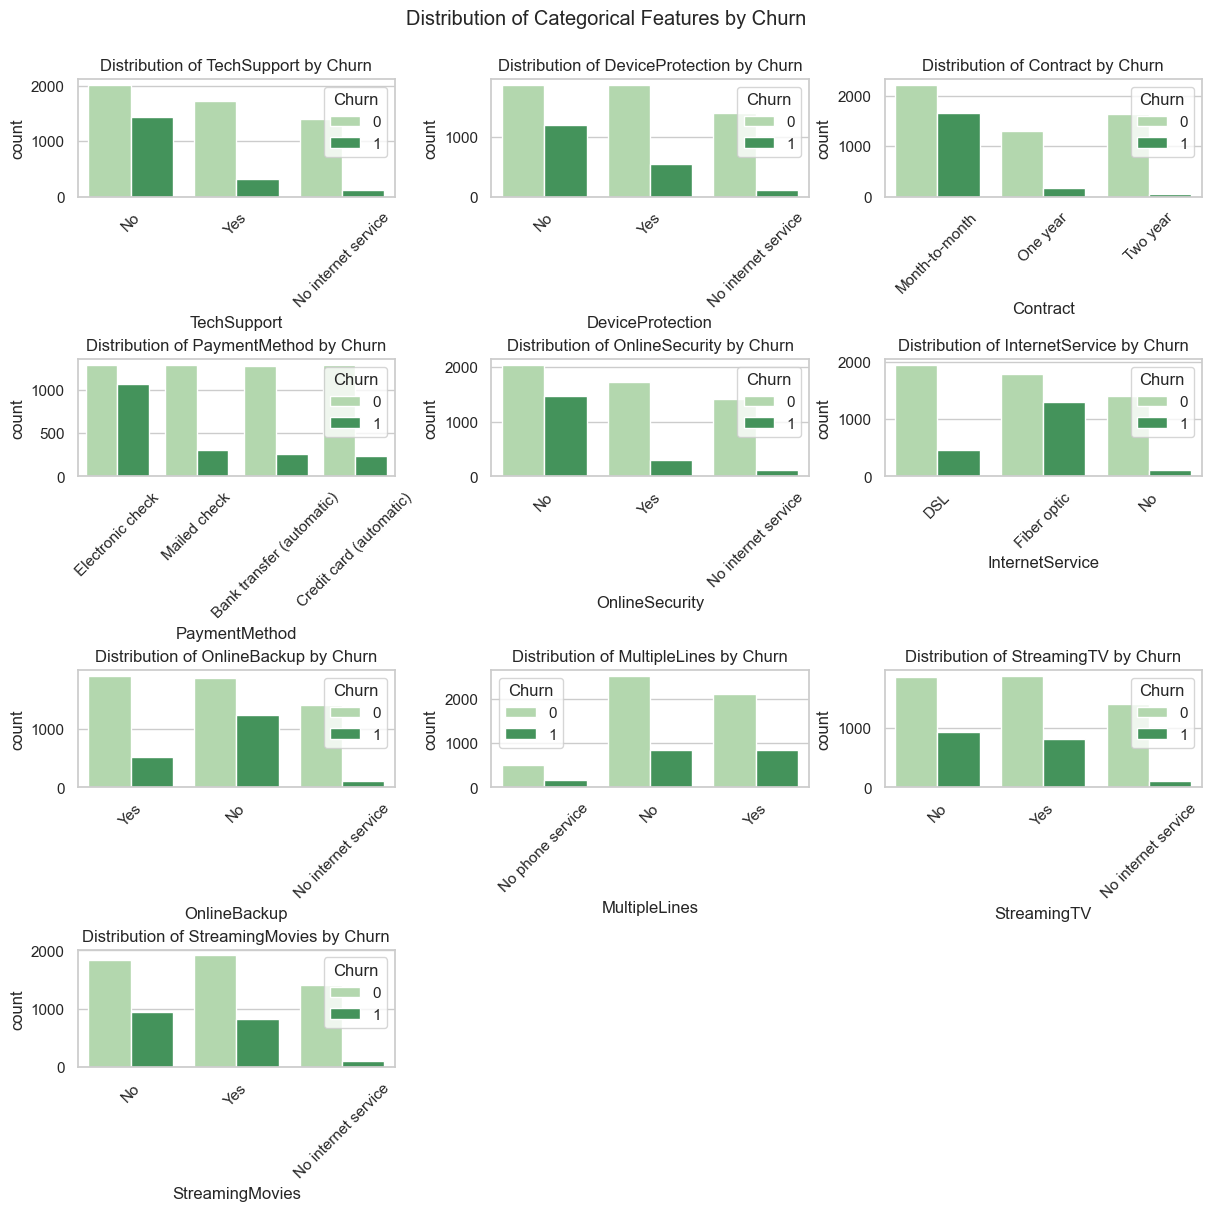

In [21]:
# Creating Plot Context
n_cols = 3
n_rows = (len(categorical_features) + n_cols - 1) // n_cols

# Creating the Figure
fig, axes = plt.subplots(n_rows, n_cols, figsize = (12, n_rows * 3), constrained_layout = True)
axes = axes.flatten()

# Creating the Plots
for i, col in enumerate(categorical_features):
    ax = axes[i]
    sns.countplot(data = df, x = col, hue = target, palette = 'Greens', ax = ax)
# Customising the Plots
    ax.set_title(f'Distribution of {col} by Churn')
    ax.tick_params(axis = 'x', rotation = 45)

# Customising the Figure
for j in range(len(categorical_features), len(axes)):
    axes[j].axis('off')
fig.suptitle('Distribution of Categorical Features by Churn\n')

# Showing the Plot
plt.show();


From the grouped count plots, we can see how different categories relate to the target variable `Churn`. Some features show a clear difference between customers who churned and those that did not.

For example, customers on **month-to-month** contracts show a higher churn rate compared to those on one or two-year contracts. This shows that customers with flexible plans are the ones that tend to leave. Similarly, customers who use **electronic check** as their payment method also have higher churn. 

Service-related features like **OnlineSecurity**, **TechSupport** and **DeviceProtection** also show strong patterns. In essence, churn is higher in customers that do not use these services. This suggests that customers who feel less supported or protected are more likely to leave. 

Overall, contract type, payment method and use of support-related services appear to have the strongest correlation with churn.

## Data Preprocessing
Having completed the EDA process and identified the features that are significant for predicting churn, we now need to preprocess the data to prepare it for modelling. Some of the following analyses are only possible after preprocessing and this include actions such as:
1. Encoding Categorical Features
2. Scaling Numerical Features

The dataset has binary, categorical and numerical features and we will handle each type appropriately:
1. **Binary Features**: Convert binary features to numerical values (0 and 1)
2. **Categorical Features**: Use one-hot encoding for categorical features with more than two categories
3. **Numerical Features**: Scale numerical features to have a mean of 0 and a unit variance. 

In order to have reusable code, we will create a `load_preprocess` function that loads the dataset and preprocesses it based on the parameters passed to it. The following are the steps we will take in the `load_preprocess` function:
1. Load the dataset from the given path
2. Drop the `customerID` column as it has no predictive value
3. Convert `TotalCharges` to numeric and drop the NaN values
4. Encode the binary features to numerical values i.e. 0 and 1
5. Map `gender` to 0 and 1
6. One-hot encode categorical features with more than two categories
7. Scale numerical features using `StandardScaler`

In [22]:
# Creating a loading and preprocessing function
def load_preprocess(filename, drop_aux, one_hot, encode_binary, encode_gender, to_numeric, scale_numeric) -> pd.DataFrame:
    churn_df = pd.read_csv(file_path, delimiter = ',')
    if drop_aux:
        # Dropping customerID
        churn_df = churn_df.drop(columns = ['customerID'])
    
    if one_hot:
        ohe = OneHotEncoder(categories = 'auto', sparse_output = False, handle_unknown = 'ignore')
        
        # Transforming & Fitting Categorical Columns
        categorical_features_encoded = ohe.fit_transform(churn_df[categorical_features])

        # Making the transformed data into a DataFrame
        column_names = ohe.get_feature_names_out(categorical_features)
        categorical_features_encoded = pd.DataFrame(data = categorical_features_encoded, columns = column_names, index = churn_df.index)

        # Dropping Categorical Features from Orignial DataFrame
        churn_df = churn_df.drop(columns = categorical_features)

        # Concatenating Encoded Columns
        churn_df = pd.concat([churn_df, categorical_features_encoded], axis = 1)

    if encode_binary:
        # Features for Mapping
        mapping_features = ['Partner', 'Dependents', 'PhoneService', 'PaperlessBilling', 'Churn']

        # Mapping of `Yes` and `No` to `1` and `0`
        for col in mapping_features:
            churn_df[col] = churn_df[col].map({'Yes': 1, 'No': 0})
    
    if encode_gender:
        # Mapping 'Male'/'Female' to 1/0
        churn_df['gender'] = churn_df['gender'].map({'Male': 1, 'Female': 0})
    
    if to_numeric:
        # Convert Total Charges to Numeric & Drop NaN values
        churn_df['TotalCharges'] = pd.to_numeric(churn_df['TotalCharges'], errors = 'coerce')
        churn_df = churn_df.dropna(subset = ['TotalCharges'])
        
    if scale_numeric:
        # Standardising Numeric Features
        scaler = StandardScaler()
        churn_df[numeric_features] = scaler.fit_transform(churn_df[numeric_features])

    return churn_df

In [23]:
# Loading and preprocessing the data
df = load_preprocess(filename = file_path,
                     drop_aux = True,
                     one_hot = True,
                     encode_binary = True,
                     encode_gender = True,
                     to_numeric = True,
                     scale_numeric = True
                     )

# Preview
df.head()

,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,PaperlessBilling,MonthlyCharges,TotalCharges,Churn,...,OnlineBackup_Yes,MultipleLines_No,MultipleLines_No phone service,MultipleLines_Yes,StreamingTV_No,StreamingTV_No internet service,StreamingTV_Yes,StreamingMovies_No,StreamingMovies_No internet service,StreamingMovies_Yes
0,0,0,1,0,-1.280248,0,1,-1.161694,-0.994194,0,...,1.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
1,1,0,0,0,0.064303,1,0,-0.260878,-0.173740,0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
2,1,0,0,0,-1.239504,1,1,-0.363923,-0.959649,1,...,1.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
3,1,0,0,0,0.512486,0,0,-0.747850,-0.195248,0,...,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0
4,0,0,0,0,-1.239504,1,1,0.196178,-0.940457,1,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0


### Correlation of All Features with Target
Having preprocessed all the columns, we can now look at the correlation of all features with `Churn` which is the target variable. This will help us understand the features that are most relevant in predicting churn.

Since a heatmap of this size (41 columns) would be difficult to read, we will opt for a bar chart to represent the same.

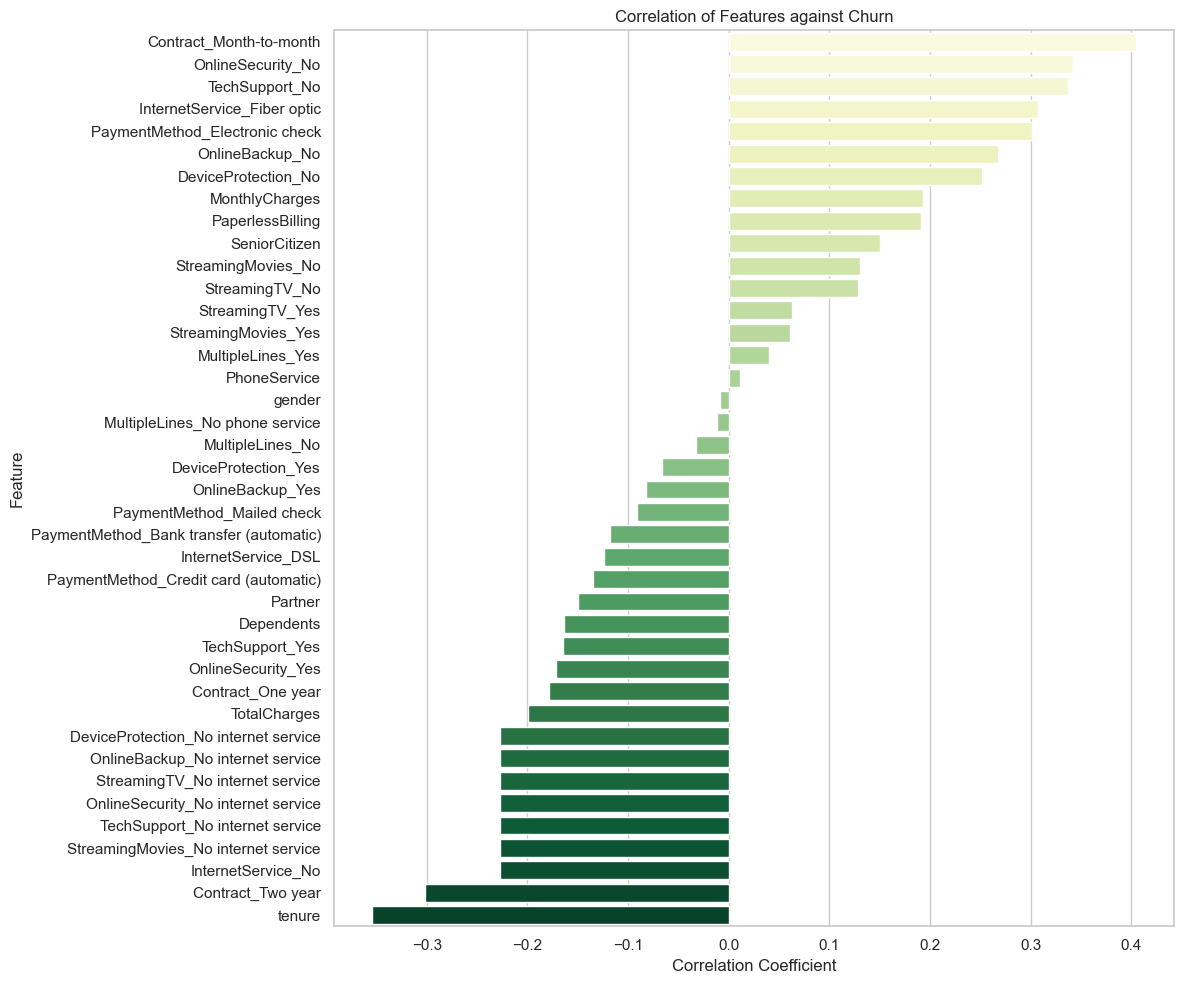

In [24]:
# Computing Correlations with the Target
churn_corr = df.corr(numeric_only = True)['Churn'].drop('Churn').sort_values(ascending = False)

# Creating the Figure
plt.figure(figsize = (12, 10))

# Plotting the Correlation
sns.barplot(x = churn_corr.values, y = churn_corr.index, hue = churn_corr.index, palette = 'YlGn', legend = False)

# Customising the plot
plt.title('Correlation of Features against Churn')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Feature')
plt.grid(True, axis = 'x')
plt.tight_layout()

# Showing the Plot
plt.show();

This bar plot shows how much each feature is related to `Churn`. Features like `Contract_Month-to-month` and `OnlineSecurity_No` have the strongest correlations with `Churn`. This means that customer profiles with these characteristics are likely to leave. In contrast, `Contract_Two year` and `tenure` have a strongly negative correlation which suggests that these customers are likely to stay.

Many features have very low or near-zero correlation with churn. This cannot be summarised as their lack of importance but that the relationship they may have with churn is likely not linear. 

The correlation analysis reveals that customers with **month-to-month contracts**, **no online security** and **no tech support** are more likely to churn. In contrast, customers with **longer tenures**, **two-year contracts** and **no internet service** have lower churn rates. These are patterns that highlight the features that are most predictive and will inform our feature selection and subsequent model design.

## Model Assessment
### Model Selection
We will assess the performance of various classification models on the churn prediction task. The models we will evaluate include:
1. **Logistic Regression**: This will serve as our baseline linear model
2. **Random Forest**: An ensemble model that builds multiple decision trees
3. **Support Vector Machine**: A powerful model that finds the optimal hyperplane for classification

### Evaluation Metrics
We will use the following evaluation metrics to assess model performance:
1. Accuracy: The proportion of correct predictions out of total predictions.
2. Precision: The proportion of true positive predictions out of all positive predictions.
3. Recall: The proportion of true positive predictions out of all actual positive cases.
4. F1_Score: The harmonic mean of precision and recall, providing a balance between
the two.
5. roc_auc: The area under the R
OC curve, which measures the model's ability to
distinguish between classes.
6. Conf
usion Matrix: A table that summarizes the performance of the classification
model by showing true positives, true negatives, false positives, and false negatives.

In [25]:
# Loading and preprocessing the data
df = load_preprocess(filename = file_path,
                     drop_aux = True,
                     one_hot = True,
                     encode_binary = True,
                     encode_gender = True,
                     to_numeric = True,
                     scale_numeric = False
                     )

Something to note is that we re-imported and preprocessed the data again. This time, however, we did not scale the numeric. This is because scaling the numeric before performing the train-test split increases the risk of data leakage and as such we will perform the scaling after splitting the dataset.

#### Handling Class Imbalance with SMOTE
In our dataset, the target variable `Churn` is moderately imbalanced with an approximately **73% non-churn** and a **27% churn** rate. This imbalance can lead to biased model performance. This is where the classifiers favour the majority class and will fail to correctly identify minority class instances i.e. Churned Customers. 

Such a bias is particularly problematic in cases where the model predictions are crucial as they partain to strategic business action as in this example.

To address this risk, I employed **SMOTE** on the training data. SMOTE works by creating synthetic examples of the minority classes based on feature space similarities between existing minority samples. This method helps balance the dataset without simply duplicating existing instances.

Again, we will **only apply SMOTE to the training set** to avoid data leakage.

#### Using Pipeline for Preprocessing and Model Training
In order to streamline the preprocessing and model training process, we will employ `Pipeline` from `imblearn`. This will allow us to combine preprocessing steps like scaline and SMOTE with our model training to one single workflow ensuring that all preprocessing is applied consistently to both training and test data.

#### Hyperparameter Tuning
For each model, we will perform hyperparameter tuning using `GridSearchCV` to find the best parameters that maximise the evaluation metrics.

For the scoring models, considering our target variable is imbalanced, we will use `roc_auc` as the scoring metric. This metric is suitable for imbalanced datasets as it evaluates the model's ability to distinguish between classess across all thresholds rather than a single point.

#### K-Fold Cross Validation
To ensure robust model evaluation, we will use K-Fold cross validation. This technique splits the datasets into K subsets (folds) and trains the models K times, each time using a different fold as the test set and the remaining folds as the training set. 

This will help us get a more reliable estimate of model performance by averaging the results across multiple splits. We use 5-fold cross-validation for all models, which is a common choice that balances computational efficiency and reliability.

First, we will make out `train-test-split` from SciKit Learn's `model_selection`. We will use 80% of our data for the training and the rest for testing. We will also employ the use of a random seed for reproducibility.

In [26]:
# Defining the X and the y
X = df.drop(columns = ['Churn'])
y = df['Churn']

# Performing the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testing_size, random_state = rand_state)

#### Logistic Regression
We will start with `LogisticRegression` which is a simple yet effective model for binary classification tasks. We will use `LogisticRegression` from `sklearn.linear_model` and apply it within a pipeline that includes scaling and SMOTE. For hyperparameter tuning, as stated earlier, we will `GridSearchCV` to find the best model parameters. 

The parameters we will tune include:
1. `C`: Inverse of regularisation strength (default is 1.0)
2. `penalty`: Type of regularisation to apply (default is 'I2')
3. `max_iter`: Maximum number of iterations for convergence (default is 100)

In [27]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a logistic regression model
lr_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state=42)),
    ('scaler', StandardScaler()),       # Scale it down – mean=0, std=1, no funny business
    ('clf', LogisticRegression(random_state=42, solver='liblinear'))
    ])

# Define the grid of hyperparameters to try for the logistic regression model
lr_param_grid = {
    'clf__C': [0.01, 0.1, 1, 10, 100],          # Regularization strength
    'clf__penalty': ['l1', 'l2'],               # Penalty type
    'clf__max_iter': [100, 200, 300, 500, 1000]
}

# Set up a grid search with cross-validation to find the best combo of parameters
lr_grid_search = GridSearchCV(
    lr_pipeline,
    lr_param_grid,
    cv = k_folds,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

# Train the model and let the grid search work its magic
lr_grid_search.fit(X_train, y_train)

# Print the best set of parameters found – the winning combo
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 50 candidates, totalling 250 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


Having trained the mode, we will evaluate its performance. We store evaluation metrics in a dictionary for easy comparison later on. Additionally, we will store extra information on the model, such as the best parameters, confustion matrix, `fpr`, `tpr` and `roc_auc` which we wll use in plotting the ROC curve.

In [28]:
# Make predictions on the test set
lr_y_pred = lr_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
lr_y_proba = lr_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_y_proba)

# Calculate ROC AUC score – area under the curve
lr_roc_auc = roc_auc_score(y_test, lr_y_proba)

# Storing all the important performance metrics and artifacts in a dictionary for later use or plotting
results["Logistic Regression"] = {
    "values": {
        "accuracy": accuracy_score(y_test, lr_y_pred),
        "precision": precision_score(y_test, lr_y_pred),
        "recall": recall_score(y_test, lr_y_pred),
        "f1": f1_score(y_test, lr_y_pred),
        "roc_auc": roc_auc_score(y_test, lr_y_proba),
    },
    "roc_curve": {
        "fpr": lr_fpr,
        "tpr": lr_tpr,
        "roc_auc": lr_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, lr_y_pred),
    "model": lr_grid_search.best_estimator_,
    "params": lr_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, lr_y_pred))

              precision    recall  f1-score   support

           0       0.89      0.73      0.80      1033
           1       0.50      0.75      0.60       374

    accuracy                           0.73      1407
   macro avg       0.69      0.74      0.70      1407
weighted avg       0.79      0.73      0.75      1407



#### Support Vector Machine Classifier
Next, we will use the Support Vector Machine (SVM) classifier using `SVC` from `sklearn.svm`. We will also use a pipeline that includes SMOTE.

We will still use `GridSearchCV` to tune hyperparameters of the SVM model. The parameters we wil tune include:
1. `C`: Regularisation parameter (default is 1.0)
2. `kernel`: Type of kernel to use (default is 'rbf')
3. `gamma`: Kernel coefficient (default is 'scale')

In [29]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a support vector classifier
svm_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state = 42)),
    ('scaler', StandardScaler()),
    ('clf', SVC(probability = True, random_state = 42))
])

svm_param_grid = {
    'clf__C': [0.1, 1, 10],
    'clf__kernel': ['linear', 'rbf'],
    'clf__gamma': ['scale', 'auto']
}

svm_grid_search = GridSearchCV(
    svm_pipeline,
    svm_param_grid,
    cv = k_folds,
    scoring = 'f1',
    n_jobs = -1,
    verbose = 1
)

svm_grid_search.fit(X_train, y_train)
print("Best parameters:", svm_grid_search.best_params_)

Fitting 5 folds for each of 12 candidates, totalling 60 fits
Best parameters: {'clf__C': 0.1, 'clf__gamma': 'scale', 'clf__kernel': 'rbf'}


In [30]:
# Make predictions on the test set
svm_y_pred = svm_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
svm_y_proba = svm_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
svm_fpr, svm_tpr, _ = roc_curve(y_test, svm_y_proba)

# Calculate ROC AUC score – area under the curve
svm_roc_auc = roc_auc_score(y_test, svm_y_proba)

# Store all the important performance metrics and artifacts in a dictionary for later use or plotting
results["SVM"] = {
    "values": {
        "accuracy": accuracy_score(y_test, svm_y_pred),
        "precision": precision_score(y_test, svm_y_pred),
        "recall": recall_score(y_test, svm_y_pred),
        "f1": f1_score(y_test, svm_y_pred),
        "roc_auc": roc_auc_score(y_test, svm_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": svm_fpr,
        "tpr": svm_tpr,
        "roc_auc": svm_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, svm_y_pred),
    "model": svm_grid_search.best_estimator_,
    "params": svm_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.69      0.59       374

    accuracy                           0.75      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.75      0.76      1407



#### Random Forest Classifier
Next, we will employ the `RandomForestClassifier` from `sklearn.ensemble`. We will also use a pipeline that includes scaling and SMOTE. We will use `GridSearchCV` to tune the hyperparameters of the Random Forest model. 

The parameters include:
1. `n_estimators`: Number of trees in the forest(default is 100)
2. `max_depth`: Maximum depth of the treee (default is None)
3. `min_samples_split`: Minimum number of samples required to split an internal node (default is 2)
4. `min_samples_leaf`: Minimum number of samples required to be a leaf node (default is 1)

In [31]:
# Build a pipeline that balances data (SMOTE), scales features, and fits a logistic regression model
rf_pipeline = ImbPipeline([
    ('smote', SMOTE(random_state = 42)),
    ('clf', RandomForestClassifier(random_state = 42))
])

# Define the grid of hyperparameters to try for the logistic regression model
rf_param_grid = {
    'clf__n_estimators': [50, 100, 200],
    'clf__max_depth': [None, 10, 20, 30],
    'clf__min_samples_split': [2, 5, 10],
    'clf__min_samples_leaf': [1, 2, 4]
}

# Set up a grid search with cross-validation to find the best combo of parameters
rf_grid_search = GridSearchCV(
    rf_pipeline,
    rf_param_grid,
    cv = k_folds,
    scoring='f1',
    n_jobs=-1,
    verbose=1
)

# Train the model and let the grid search work its magic
rf_grid_search.fit(X_train, y_train)

# Print the best set of parameters found – the winning combo
print("Best parameters:", lr_grid_search.best_params_)

Fitting 5 folds for each of 108 candidates, totalling 540 fits
Best parameters: {'clf__C': 0.01, 'clf__max_iter': 100, 'clf__penalty': 'l1'}


In [32]:
# Make predictions on the test set
rf_y_pred = rf_grid_search.predict(X_test)

# Get the predicted probabilities for the positive class (1)
rf_y_proba = rf_grid_search.predict_proba(X_test)[:, 1]

# Compute ROC curve values
rf_fpr, rf_tpr, _ = roc_curve(y_test, rf_y_proba)

# Calculate ROC AUC score – area under the curve
rf_roc_auc = roc_auc_score(y_test, rf_y_proba)

# Store all the important performance metrics and artifacts in a dictionary for later use or plotting
results["Random Forest"] = {
    "values": {
        "accuracy": accuracy_score(y_test, rf_y_pred),
        "precision": precision_score(y_test, rf_y_pred),
        "recall": recall_score(y_test, rf_y_pred),
        "f1": f1_score(y_test, rf_y_pred),
        "roc_auc": roc_auc_score(y_test, rf_grid_search.predict_proba(X_test)[:, 1]),
    },
    "roc_curve": {
        "fpr": rf_fpr,
        "tpr": rf_tpr,
        "roc_auc": rf_roc_auc,
    },
    "confusion_matrix": confusion_matrix(y_test, rf_y_pred),
    "model": rf_grid_search.best_estimator_,
    "params": rf_grid_search.best_params_,
}

# Print the full classification report – like a detailed report card for your model
print(classification_report(y_test, svm_y_pred))

              precision    recall  f1-score   support

           0       0.87      0.77      0.82      1033
           1       0.52      0.69      0.59       374

    accuracy                           0.75      1407
   macro avg       0.69      0.73      0.70      1407
weighted avg       0.78      0.75      0.76      1407



##### Random Forest Feature Importance
A cool feature of Random Forest is its ability to provide feature importance scores. These scores indicate how much each feature contributes to the model's predictions. We can visualise these importances using a bar plot.

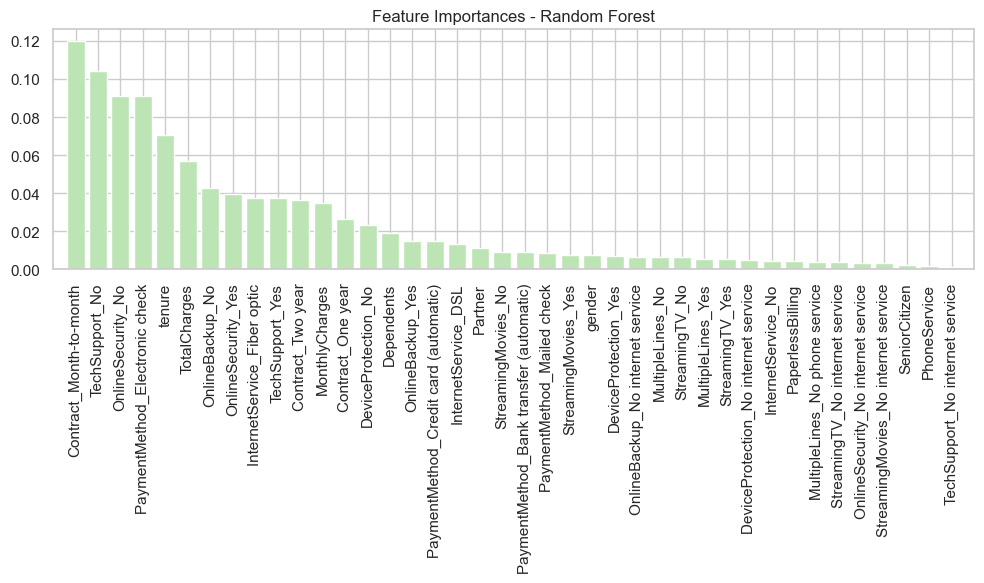

In [33]:
# Feature importance for Random Forest
importances = rf_grid_search.best_estimator_.named_steps['clf'].feature_importances_
feature_names = X.columns
indices = importances.argsort()[::-1]

# Creating the Figure
plt.figure(figsize=(10, 6))

# Creating the Plot
plt.bar(range(X.shape[1]), importances[indices], align='center', color = sns.color_palette("Greens")[1])

# Customising the Plot
plt.title("Feature Importances - Random Forest")
plt.xticks(range(X.shape[1]), feature_names[indices], rotation=90)
plt.xlim([-1, X.shape[1]])
plt.tight_layout()
plt.show()

The plot shows that `Contract_Month-to-month`, `OnlineSecurity_No` and `PaymentMethod_Electronic check` as the top three most important features for predicting churn.

### Model Comparison
Now that all models are trained, we will compare their performance based on the valuation metrics we defined earlier. We will also create a summary table that will be used for the display of the results of each model's metrics. 

We will plot the ROC curves for each model to visualise their performance. We will then plot confusion matrices for all the models to see how well they classify churned and non_churned customers.

#### Plotting Model Performance
Here we will use a bar plot comparing the performance of each model based on the evaluation metrics.

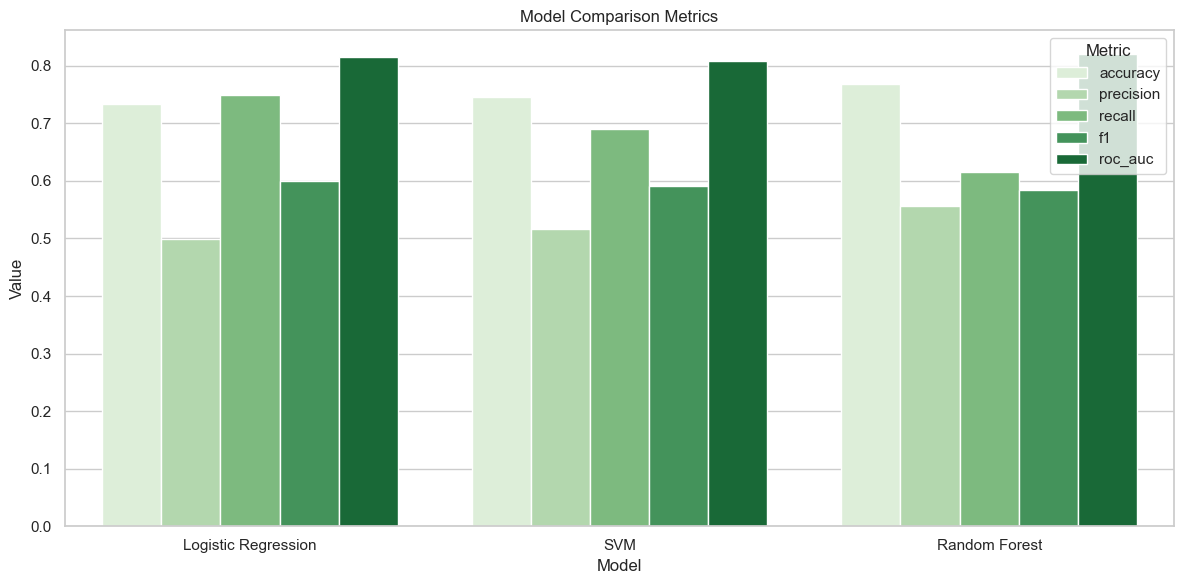

In [34]:
# Model Metric Comparison
dynamic_df = pd.DataFrame.from_dict(
    {k: v["values"] for k, v in results.items()},
    orient='index'
).reset_index().rename(columns={'index': 'Model'})

dynamic_df = dynamic_df.melt(id_vars = 'Model', var_name = 'Metric', value_name = 'Value')

# Creating the Figure
plt.figure(figsize=(12, 6))

# Create the Plot
sns.barplot(data = dynamic_df, x='Model', y='Value', hue = 'Metric', palette = 'Greens')

# Customising the Plot
plt.title('Model Comparison Metrics')
plt.tight_layout()

# Showing the Plot
plt.show()

#### Storing the Results
Now, we will look at the same data in tabular format for better readability. Here we will create a dataframe to store the results as well as saving it to csv for future reference.

In [35]:
# Saving off the results
results_df = pd.DataFrame.from_dict(
    {model: res["values"] for model, res in results.items()},
    orient='index'
)

results_df.to_csv(f"{result_path}{result_name}{datetime.now().strftime('%Y%m%d_%H%M%S')}.{result_ext}")
results_df

,accuracy,precision,recall,f1,roc_auc
Logistic Regression,0.733475,0.499109,0.748663,0.598930,0.814449
SVM,0.746269,0.517034,0.689840,0.591065,0.808941
Random Forest,0.767591,0.556901,0.614973,0.584498,0.820382


#### Confusion Matrix
We now look at the cofusion matrices for all of the models to see how well the classify the churned and non-churned customers. Here we will see the numer of True Positives, False Positives, True Negatives and False Negatives.

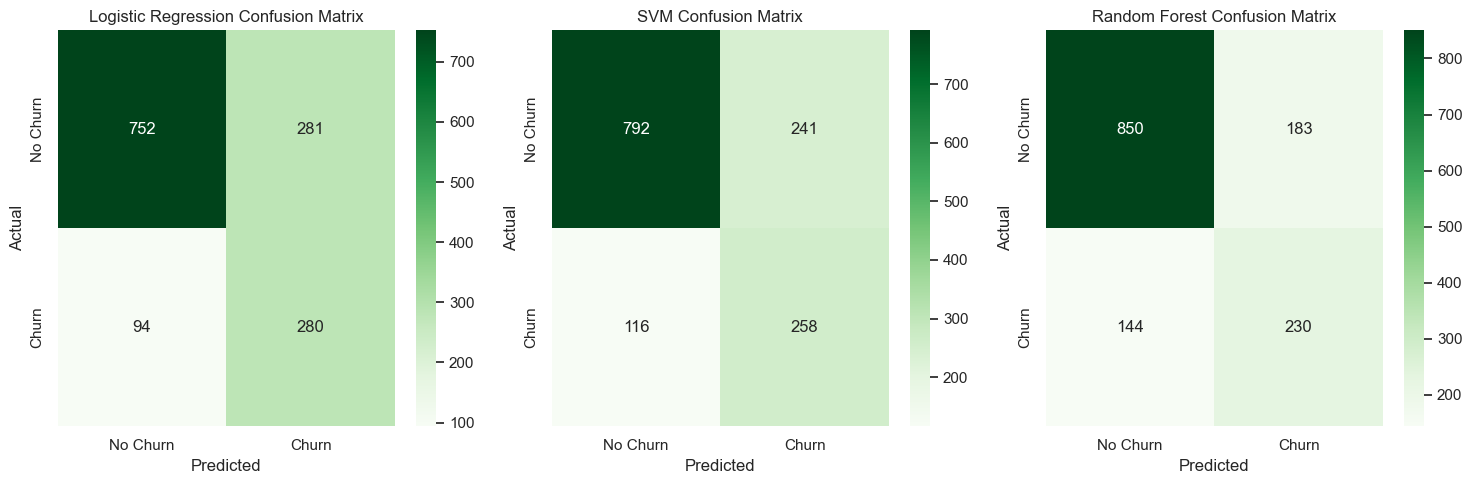

In [36]:
# Plotting Confusion Matrices
n_models = len(results)
cols = 3
rows = (n_models + cols - 1) // cols

# Creating the Figure
fig, axes = plt.subplots(rows, cols, figsize=(15, 5 * rows))
axes = axes.flatten() if n_models > 1 else [axes]

# Creating the Plot
for i, (model_name, res) in enumerate(results.items()):
    cm = res["confusion_matrix"]
    sns.heatmap(cm, annot = True, fmt = 'd', cmap = 'Greens', ax = axes[i])

    # Customising the Plot
    axes[i].set_title(f"{model_name} Confusion Matrix")
    axes[i].set_xlabel("Predicted")
    axes[i].set_ylabel("Actual")
    axes[i].set_xticklabels(["No Churn", "Churn"])
    axes[i].set_yticklabels(["No Churn", "Churn"])
plt.tight_layout()

# Showing the Plot
plt.show();

#### ROC Curve
Finally, we will plot the ROC curve for each model to visualise their performances in terms of true positive rate (sensitivity) and false positive rate (1 - sensitivity). The ROC curve shows how well the model distiguishes between churned and non-churned customrs at different thresholds.

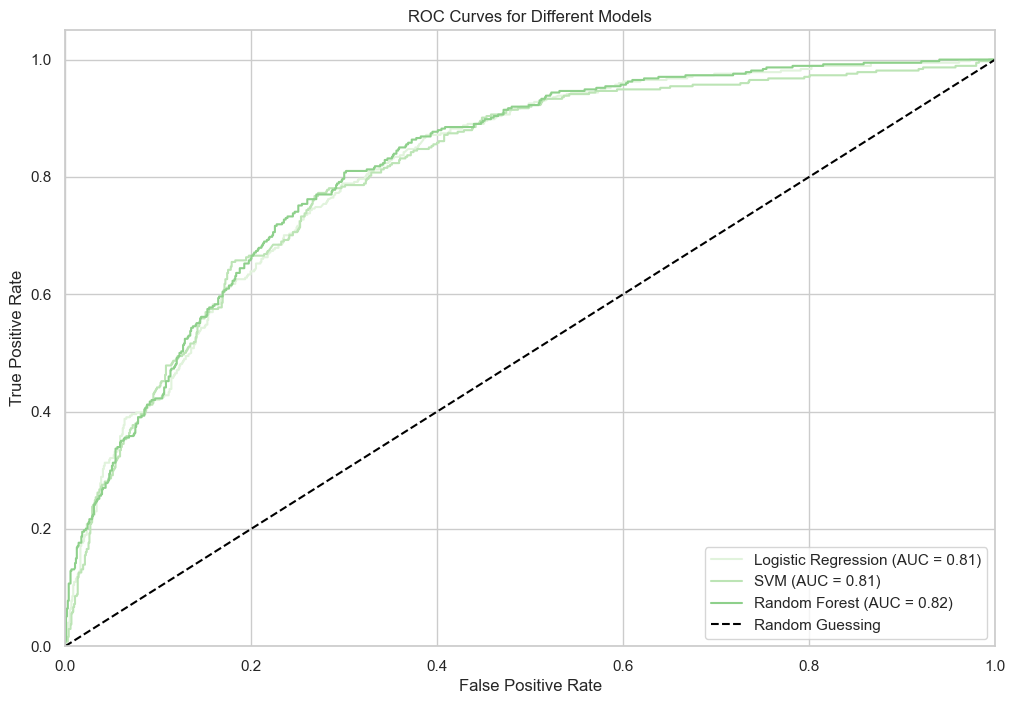

In [37]:
# Plotting the ROC Curves

# Creating the Figure
plt.figure(figsize=(12, 8))

for model_name, res in results.items():
    fpr = res["roc_curve"]["fpr"]
    tpr = res["roc_curve"]["tpr"]
    auc_score = res["roc_curve"]["roc_auc"]
    plt.plot(fpr, tpr, label=f"{model_name} (AUC = {auc_score:.2f})")
plt.plot([0, 1], [0, 1], 'k--', label='Random Guessing')

# Customising the Plot
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.legend(loc="lower right")
plt.title('ROC Curves for Different Models')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.grid(True)

# Showing the Plot
plt.show();

##### ROC Curve Analysis
The **ROC curve** helps evaluate how well each model can distinguish between churn and non-churn customers. It plots the **True Positive Rate (TPR)** and the **False Positive Rate (FPR)** across different thresholds. The main summary metric is the **Area Under the Curve (AUC)**, the higher the AUC, the better the model is at classification.

From the ROC curve and AUC scores:
- **Random Forest** achieved the highest AUC of **0.82**, showing that it is the best at separating the two classes among all the employed models. 
- **Logistic Regression** and **SVM** perform similarly with AUC scores of **0.814** and **0.809**, respectively. These models are still effective but slightly weaker than the Random Forest.

Overall, **all models performed better than random guessing (AUC 0.5)** with the Random Forest topping it off as the only ensemble model.

### Model Perfomance Comparison
To evaluate the models on the Telka Customer Churn, we considered and used five classification metrics:
1. Accuracy
2. Precision
3. Recall
4. F1-score
5. ROC AUC

These metrics help us understand each model's strenths and weaknesses especially considering that the dataset is quite imbalanced.
| Model              | Accuracy | Precision | Recall  | F1 Score | ROC AUC  |
|--------------------|----------|-----------|---------|----------|----------|
| Logistic Regression| 0.733475 | 0.499109  | 0.748663| 0.598930 | 0.814447 |
| SVM                | 0.746269 | 0.517034  | 0.689840| 0.591065 | 0.808941 |
| Random Forest      | 0.773987 | 0.568627  | 0.620321| 0.593350 | 0.821774 |

#### Accuracy
The **Random Forest** model achieved the highest accuracy score at 0.77. This means that it made the most correct precictions overall. However, considering that the dataset is imbalanced, accuracy as a score is not sufficient as a standalone performance measure.

#### Precision and Recall
- **Precision** reflects how many of the predicted churners were actually correct. Random Forest had the highest precision (0.57) showing that it was more selective when predicting churn.
- **Recall** shows how many churners were successfully classified. Logistic Regression was the best performer in this, which is important in the decision making of customer retention strategies.

#### F1-Score
The f1-score is the harmonic mean of precision and recall. Here, Logistic Regression performed best at 0.598 showing a balanced tradeoff.

#### ROC AUC
The ROC AUC score shows the models capability to separate churners from non-churners across the thresholds. Here, Random Forest performed best at ranking customers by their likelihood to churn with a score of 0.821.

#### Conclusion
Each model brings something to the table in the Telka churn prediction task:
- Logistic Regression stands out in recall (0.75), making it the best at flagging actual churners. It is suitable when the goal is to capture as many churners as possible.
- SVM offers a balanced performance, with decent scores across the board. As a model, it is more useful when false positives are more costly.
- Random Forest is the overall strongest performer in terms of accuracy, precision, and ROC AUC. It makes the most correct predictions, is more confident when it says someone will churn, and separates churners from non-churners the best. This makes it a top pick.

In conclusion, **Random Forest is the best model** for this churn prediction task. It strikes the best balance between identifying churners accurately and minimizing false alarms. This is while also ranking customers effectively by churn risk which is a win-win for both retention strategies and business impact.

## Feature Engineering
Feature engineering simply means creating new features or changing existing ones to help the model learn better. 

In this part we create an **interaction feature** to help the model understand how the two values work together.

### Create Interaction Feature
We will add a new feature, `tenure_x_MonthlyCharges`, which will be the product of `tenure` and `MonthlyCharges`. This captures the relationship between how long a customer stays at Telka (`tenure`) and how much they pay monthly (`MonthlyCharges`). It may help the model understand that customers who have been with the company longer and pay more might be less likely to churn.

In [41]:
# Loading and preprocessing the data
df = load_preprocess(filename = file_path,
                     drop_aux = True,
                     one_hot = True,
                     encode_binary = True,
                     encode_gender = True,
                     to_numeric = True,
                     scale_numeric = False
                     )

# Defining the X and the y
X = df.drop(columns = ['Churn'])
y = df['Churn']

# Performing the Train-Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = testing_size, random_state = rand_state)

# Scale numeric features
scaler = StandardScaler()
num_cols = ['tenure', 'MonthlyCharges', 'TotalCharges']
X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

# Model 1: Baseline Logistic Regression
lr1 = LogisticRegression(random_state = rand_state, max_iter = 1000)

lr1.fit(X_train, y_train)
y_pred1 = lr1.predict(X_test)
y_proba1 = lr1.predict_proba(X_test)[:, 1]

results_1 = {}
results_1["Logistic Regression (no new feature)"] = {
                                                    "accuracy": accuracy_score(y_test, y_pred1),
                                                    "precision": precision_score(y_test, y_pred1),
                                                    "recall": recall_score(y_test, y_pred1),
                                                    "f1": f1_score(y_test, y_pred1),
                                                    "roc_auc": roc_auc_score(y_test, y_proba1),
                                                    }

In [42]:
# Model 2: With Interaction Feature
X_train2 = X_train.copy()
X_test2 = X_test.copy()

# Create the interaction term: tenure * MonthlyCharges
X_train2['tenure_x_MonthlyCharges'] = X_train2['tenure'] * X_train2['MonthlyCharges']
X_test2['tenure_x_MonthlyCharges'] = X_test2['tenure'] * X_test2['MonthlyCharges']

# Train logistic regression with the interaction term
lr2 = LogisticRegression(random_state=42, max_iter=500)
lr2.fit(X_train2, y_train)

# Make predictions
y_pred2 = lr2.predict(X_test2)
y_proba2 = lr2.predict_proba(X_test2)[:, 1]

# Store results
results_1["Logistic Regression (with interaction feature)"] = {
    "accuracy": accuracy_score(y_test, y_pred2),
    "precision": precision_score(y_test, y_pred2),
    "recall": recall_score(y_test, y_pred2),
    "f1": f1_score(y_test, y_pred2),
    "roc_auc": roc_auc_score(y_test, y_proba2),
}

In [43]:
# Save results to CSV
results_1_df = pd.DataFrame(results_1).T
results_1_df.to_csv(f'{result_path}/{result_name}-interaction-feature.{result_ext}')
results_1_df

,accuracy,precision,recall,f1,roc_auc
Logistic Regression (no new feature),0.788202,0.622581,0.516043,0.564327,0.831993
Logistic Regression (with interaction feature),0.788913,0.624595,0.516043,0.565154,0.831991


### Feature Engineering Analysis
Featuring engineering is the process of creating new variables or modifying existing ones to help machine learning models learn better from the data. In this case, we introduced an **interaction feature** by multiplying two numerical features: `tenure` and `MonthlyCharges`. 

The new feature, named `tenure_x_MonthlyCharges`, is designed to capture the relationship between how long a customer has been with the company and how much they pay each month. This interaction can provide extra information to the model.

To evaluate the effect of this feature, we used **Logistic Regression** as a **baseline model**. Logistic Regression was the choice model because of its simplicity, interpretable and sensitive to linear relationships between features and the target variable. 

We then compared the model performance with and without the interaction feature:
| Model                                      | Accuracy | Precision | Recall   | F1 Score | ROC AUC  |
|-------------------------------------------|----------|-----------|----------|----------|----------|
| Logistic Regression (no new feature)      | 0.788202 | 0.622581  | 0.516043 | 0.564327 | 0.831993 |
| Logistic Regression (with interaction feature) | 0.788913 | 0.624595  | 0.516043 | 0.565154 | 0.831991 |

#### Evaluation
After adding the interaction feature, all performance metrics improved slightly, including accuracy, precision, recall, f1-score and ROC AUC. Here is a summary:
- The ROC AUC score remained nearly the same (0.832), suggesting that the model's ability to rank churners versus non-churners did no change significantly. However, the improvements in other metrics show better predictive performance. 
- The resulst indicate indicate that the new feature contributes positively to the model's ability to separate the classes.

Although the improvements were modest, they were consistent across all key metrics. This shows that even a simple interaction feature can help the model perform better.

## Conclusion
This project focused on predicting customer churn using the Telco Customer Churn dataset, following a full machine learning pipeline—from data cleaning and exploratory analysis to feature engineering and model evaluation. Due to moderate class imbalance in the dataset, techniques such as SMOTE were applied to mitigate training bias and improve model performance.

Exploratory Data Analysis (EDA) revealed several important patterns. Features such as `tenure`, `MonthlyCharges`, `Contract` and use of services like `TechSupport` and `OnlineSecurity` showed strong correlations with customer churn. We also identified multicollinearity between `TotalCharges` and other numerical features, which informed our model selection and feature usage strategies.

We built and compared several classification models using the same preprocessing and evaluation methods. Among them:
- **Random Forest** emerged as the top performer overall. It delivered the highest accuracy (0.77), precision (0.57), and ROC AUC (0.82). This means it not only makes more correct predictions but also ranks customers by churn risk more reliably than the others. This ends up making it the best option for churn scoring and targeted retention.
 - **Logistic Regression**, while simpler, excelled in recall (0.75) and F1-score (0.60). It’s the strongest option when the business goal is to catch as many churners as possible, even at the risk of more false positives.
- **SVM** struck a balance across all metrics, making it a safe middle ground when both precision and recall matter equally, especially in situations where the cost of acting on a false churn prediction is high.

We introduced a new feature (`tenure * MonthlyCharges`) and evaluated its effect using Logistic Regression. This addition resulted in small but consistent improvements in all the scoring metrics.

In conclusion, `RandomForest` is the most suitable model for churn prediction in this context. The project also highlights the importance of proper preprocessing, careful metric selection for imbalanced data and the value of domain driven feature engineering. Future work could explore additional interaction features, model ensembles or deployment strategies for real-time churn risk scoring.